# INTRODUCTION

In this report, I am to explore the trends in appointments and MH infusion rates over time. By using time series regression, the goal is to study patterns and uncover insights that help us better understand the dynamics of these appointments. This analysis is crucial in identifyinh changes, pinpointing areas of concern and informing decision-making. 

I undertook the following steps; 

1. **Data Preparation:** I carefully organized and cleaned the data to ensure accuracy and consistency. 
2. **Trend Analysis:**

- Examined the overall trends of all appointments.
- Focused on successful appointments involving MH infusions within Cambridge. 
- Compared the Cambridge MH infusion rates trend with successfull MH infusion appointments outside Cambridge. 

After analyzing these trends, the next step is to identify the underlying factors that may influence the observed patterns, particularly the significant drop in MH infusions within Cambridge. This will include a comparative analysis with other locations and an investigation into potential changes that occured during mid-2023. The findings will form the foundation for actionable strategies to address these trends.  

**Load the required libraries** 

In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose 
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Load the required data
appointment_df = pd.read_csv("../data/Appointments List.csv", 
                             encoding='UTF-16', delimiter="\t")
appointment_df.head()

,Appointment UID,Appt Status Description,Date Of Service,Chartnumber,NurseName,FirstTreatmentApptInd,Appt Type Group,Appt Type,Created By,Provider,Facility City,Room,Column Heading,#,Count of tblAppointments,Patient FID
0,Grand Total,Total,Total,Total,Total,Total,Total,Total,Total,Total,Total,Total,Total,Total,"55,975",*
1,1,Made,01/01/00,NaN,NaN,N,Default,NaN,system,",",NaN,Other,NaN,1,1,1
2,109,Seen,01/22/18,1,NaN,N,Intake,TMS INTAKE DR. BRENNER,EMILY,"BRENNER,DANIEL A",CAMBRIDGE,Other,DR. BRENNER,2,1,"5,283"
3,239,Seen,01/22/18,2,NaN,N,MH Infusion,KETAMINE MH -INFUSION ONLY,EMILY,"BRENNER,DANIEL A",CAMBRIDGE,Other,2C,3,1,"5,286"
4,240,Made,01/22/18,9,NaN,N,Intake,TMS INTAKE DR. BRENNER,EMILY,"BRENNER,DANIEL A",CAMBRIDGE,Other,DR. BRENNER,4,1,"5,351"


# Explanatory Data Analysis

## Data Wrangling 

Just for a brief introduction, data wrangling is the process of transforming raw data into a structured organized format that is ready for analysis. Also referred to as **data cleaning**. 

In this analysis, the data wrangling process included the following steps; 
1. **Dropped irrelevant records:** 
The records that contained information that was not relevant for the current analysis were dropped. In this case, there was a record with the appointments dates from the year 2000 since they fell outside the scope of this study. 
2. **Standardized Appointment Categories(Labels):**
The appointment status were standardized to make them consistent and meaningful. Specifically:
- Appointments marked as "Made" were renamed to "Seen"
- Appointments marked as "Deleted" were renamed to "Cancelled". 
3. **Selected Relevant Columns** 
To prepare the data for time series regression, we identified and retained only the columns necessary for this analysis; "Date of Service" and "Appointment UID". Any records with missing values from the selected columns were removed to ensure the accuracy of the analysis. 
4. **Aggregated Data by Date:**
Finally, the total number of appointments was calculated by grouping the data by date. This allowed us to create a daily summary of all appointments, which serves as the foundation for analyzing trends over time. 

The data was therefore ready for the next phase of analysis which is time series regression. More data wrangling will be performed based on the status of the analysis. 



In [3]:
# Drop the first row of the data frame
appointment_df.drop(index=0, inplace=True)
appointment_df.reset_index(drop=True, inplace=True)

# Convert to time series data
appointment_df["Date"] = pd.to_datetime(appointment_df["Date Of Service"], errors="coerce")

# Replace "Made" to "Seen" and "Deleted" to "Cancelled"
appointment_df["Appt Status Description"].replace({
    "Made":"Seen",
    "Deleted": "Cancelled"
}, inplace=True)

appointment_ts = appointment_df[["Date","Appointment UID"]]

# Count null values 
null_values = appointment_ts.isna().sum()
print("Rows with null values: ", null_values)
del null_values # for memory management

# Count duplicated records 
duplicated_records = appointment_ts.duplicated().sum()
print("Duplicated records: ", duplicated_records)
del duplicated_records


# Remove all the null values  
appointment_ts.dropna(how="any", inplace=True)
appointment_ts.reset_index(drop=True)

# Count the null values to confirm the operation 
null_values = appointment_ts.isna().sum()
print("Rows with null values after cleaning: ", null_values)
del null_values # for memory management

# Group the data by date  
daily_appointments_ts = appointment_ts.groupby("Date").count().reset_index()
daily_appointments_ts.rename({"Appointment UID":"appointment_count"}, 
                            axis=1, inplace=True)

daily_appointments_ts.head()

Rows with null values:  Date               18726
Appointment UID        0
dtype: int64
Duplicated records:  0
Rows with null values after cleaning:  Date               0
Appointment UID    0
dtype: int64


,Date,appointment_count
0,2000-01-01,1
1,2017-12-12,1
2,2017-12-13,1
3,2017-12-14,1
4,2017-12-15,1


In [4]:
# Unique days 
appointment_ts["Date"].nunique()

1713

## Time Series Regression
### Regression Analysis

In [5]:
# Ensure the date column is sorted 
daily_appointments_ts = daily_appointments_ts.sort_values("Date").reset_index(drop=True)
daily_appointments_ts

# Drop the first column it might be an error. No possible appointment was in 2000 the next one in 2017
daily_appointments_ts.drop(index=0, inplace=True)
daily_appointments_ts.reset_index(drop=True, inplace=True)

daily_appointments_ts.head()

# Add a numeric time variable that counts days since the start 
daily_appointments_ts["Time"]  = (daily_appointments_ts["Date"] - 
                                  daily_appointments_ts["Date"].min()).dt.days

daily_appointments_ts

# Define the independent(Y) and dependent variables(X)
X = sm.add_constant(daily_appointments_ts["Time"]) # Add a constant for intercept
y = daily_appointments_ts["appointment_count"]

# Create the model 
model = sm.OLS(y, X).fit()
print(model.summary())

# Predicted Counts
predicted_counts = model.predict(X)

                            OLS Regression Results                            
Dep. Variable:      appointment_count   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     863.0
Date:                Mon, 25 Nov 2024   Prob (F-statistic):          6.49e-154
Time:                        14:02:58   Log-Likelihood:                -5956.4
No. Observations:                1712   AIC:                         1.192e+04
Df Residuals:                    1710   BIC:                         1.193e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0397      0.381     31.570      0.0

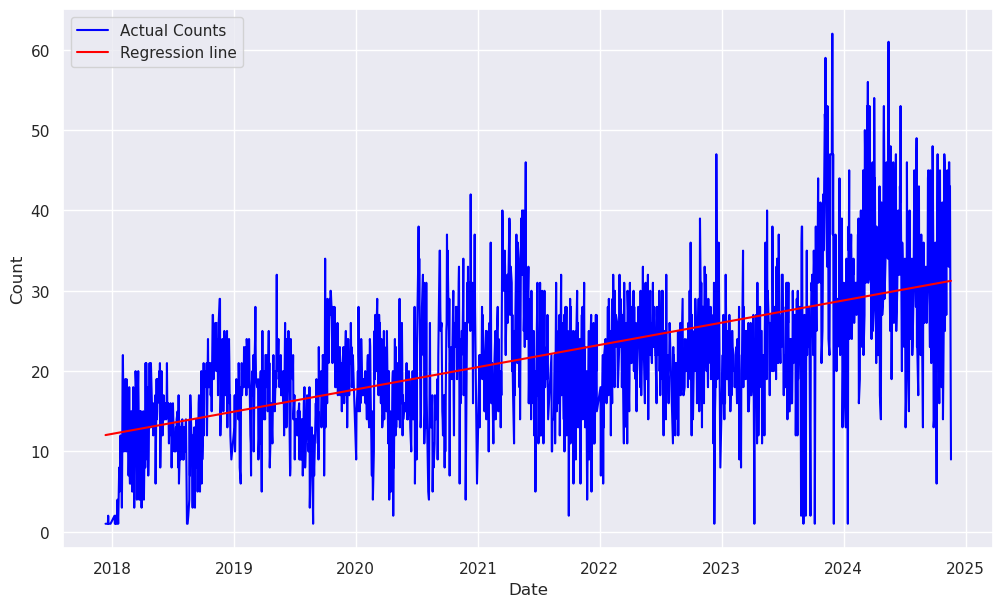

In [6]:
%matplotlib inline 
sns.set()

# Plot the results 
plt.figure(figsize = (12, 7))
plt.plot(daily_appointments_ts["Date"], daily_appointments_ts["appointment_count"],
        label = "Actual Counts", color = "blue")
plt.plot(daily_appointments_ts["Date"], predicted_counts,
        label = "Regression line", color = "red")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

### Time series Decompisition 

This was done to refine the analysis and find the details of the appointments over time. Like:

* Calculate seasonal trends
* Visualize the annual cycles 
* Visualize the daily fluctuations in the number of appointments 

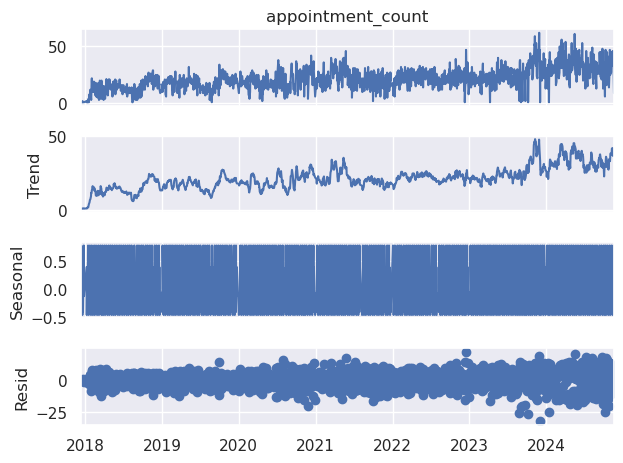

In [7]:
# Set the date as index 
daily_appointments_ts.set_index("Date", inplace=True)

# Perform decomposition
result = seasonal_decompose(daily_appointments_ts["appointment_count"], 
                           model = "additive", period=7)

# Plot the result 
result.plot()
plt.show()

Findings;

* There is an upward trend of the daily number of appointments
* daily fluctuations of the number of appointments range from 0 to 25

### Moving average

Lets smoothen the curves by calculating 7-day, 30-day and 90-day moving averages. Just to make it clear, moing average is a statistical method used to smooth time series data by calculating the average of data points over a fixed time period. For instance, our case the 7-day moving average calculates the average of the moost recent 7 days' values and continuously updates as new data points are added. This technique redices noise and highlights the underlying trends or patterns in the data, making it easier to interpret. 

As said before, the goal of this analysis is to find out, why and when did the successful appointments that involved MH infusion rates have gone down therefore calculating moving averages is essential because; 

1. **It smoothens the daily fluctuations:** Daily appointment data can be noisy and moving average smoothens these fluctuations, enabling us to focus on the overall trend rather than short-term spikes or drops. 
2. **Camparing trends:** by using different time windows(7, 30, 90 days), we can examine short-term, medium term and long-term trends providing holistic view of the data. 

These are steps that were taken; 

- Calculated 7, 30, 90 day moving averages  to highlight weekly, monthly and quarterly patterns in appointment counts and MH infusion rates. 
- Covered multiple metrics; total daily appointments, MH infusion appointments in Cambridge and outside Cambridge. 

The moving averages were plotted alongside the raw data whereby;

* the raw data was in lightblue for the daily rates(appointments, MH infusions) and displayed in the background to provide context
* the smoothed trends(7, 30, 90 day moving averages) were overlaid in distinct blue tones for clarity. 

I will provide the results of the visualizations later but here is what the charts helped me to reveal; 
- Consistent trends across different time windows, with shorter windows showing more detailed changes. 
- Difference in patters and any unusual drops or increases in appointments or infusion rates. 


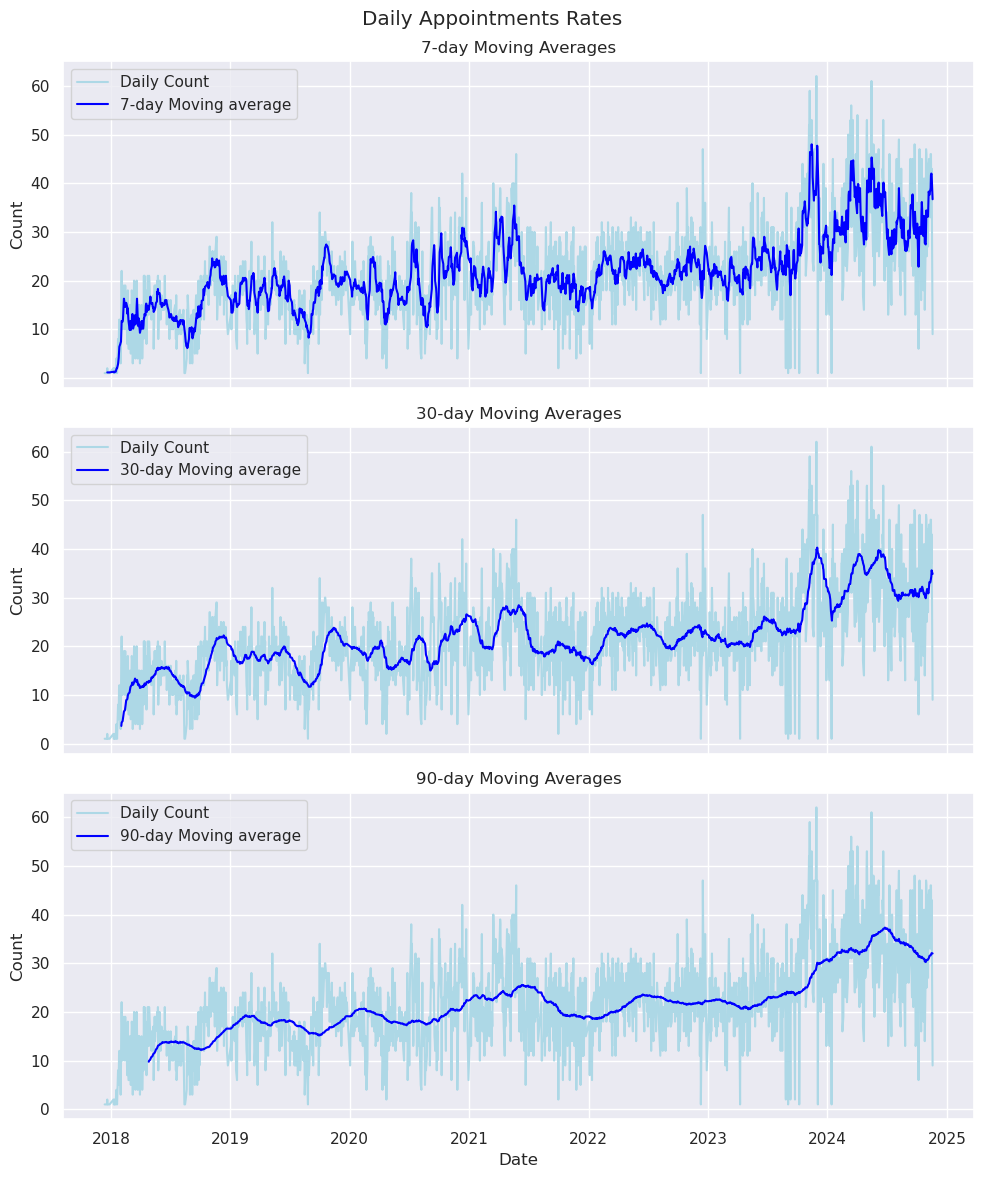

In [19]:
# Create subplots  
fig, axes = plt.subplots(nrows=3, ncols=1,
                        figsize=(10, 12), sharex=True)

# 7-day Moving average plot 
daily_appointments_ts["7_day_MA"] = daily_appointments_ts["appointment_count"].rolling(window=7).mean()
## Plotting
axes[0].plot(daily_appointments_ts.index, daily_appointments_ts["appointment_count"],
        label = "Daily Count", color="lightblue")
axes[0].plot(daily_appointments_ts.index, daily_appointments_ts["7_day_MA"],
        label = "7-day Moving average", color="blue")
axes[0].set_ylabel("Count")

axes[0].set_title("7-day Moving Averages")
axes[0].legend()

# 30-day Moving average plot 
daily_appointments_ts["30_day_MA"] = daily_appointments_ts["appointment_count"].rolling(window=30).mean()
## Plotting
axes[1].plot(daily_appointments_ts.index, daily_appointments_ts["appointment_count"],
        label = "Daily Count", color="lightblue")
axes[1].plot(daily_appointments_ts.index, daily_appointments_ts["30_day_MA"],
        label = "30-day Moving average", color="blue")
axes[1].set_ylabel("Count")

axes[1].set_title("30-day Moving Averages")
axes[1].legend()

# 90-day Moving average plot 
daily_appointments_ts["90_day_MA"] = daily_appointments_ts["appointment_count"].rolling(window=90).mean()
## Plotting
axes[2].plot(daily_appointments_ts.index, daily_appointments_ts["appointment_count"],
        label = "Daily Count", color="lightblue")
axes[2].plot(daily_appointments_ts.index, daily_appointments_ts["90_day_MA"],
        label = "90-day Moving average", color="blue")
axes[2].set_ylabel("Count")

axes[2].set_title("90-day Moving Averages")
axes[2].legend()

plt.suptitle("Daily Appointments Rates")

plt.xlabel("Date")
plt.tight_layout()
plt.show()

Here is what was discovered after analyzing daily appointment rates; 

- The daily appointment count has a general upward trend over the years. 
- There are peaks and troughs(seasonality) recurring annually. This could be due to holidays and seasonal events. 

Insights; 

- The number of appointments are growing steadily over time. Need to find the factos that increase the appointment rate. 

Lets focus on successfull MH infusion rates over the years!

#### Successful MH Infusion in Cambridge
I will narrow down to the successfull appointments with MH Infusion at cambridge all time and visualize the trend. 


First I prepared the data by: 

* Filtering to get the appointments that were successful, involved MH infusion and were held in the Cambridge facility. 
* Dropped the first record that had an appointment held in the year 2000 which was irrelevant in the analysis(this might be an error during data collection)

In [9]:
# Filter the data 
cambridge_mh_success = appointment_df[(appointment_df["Appt Status Description"]=="Seen")\
               &(appointment_df["Facility City"]=="CAMBRIDGE")\
               &(appointment_df["Appt Type Group"]=="MH Infusion")].reset_index(drop=True)


# Clean the data
## Get the required columns 
cambridge_mh_success = cambridge_mh_success[["Date", "Appointment UID"]]

## remove the null values  
cambridge_mh_success.dropna(how="any", inplace=True)
cambridge_mh_success.reset_index(drop=True, inplace=True)

## Sort values by data 
cambridge_mh_success.sort_values("Date").reset_index(drop=True)

## Group the data by date  
cambridge_mh_success = cambridge_mh_success.groupby("Date").count().reset_index()
cambridge_mh_success.rename({"Appointment UID":"appointment_count"}, 
                            axis=1, inplace=True)

## Drop the first row 
cambridge_mh_success.drop(index=0, inplace=True)
cambridge_mh_success.reset_index(drop=True)

## Set date as index
cambridge_mh_success.set_index("Date", inplace=True)

cambridge_mh_success.head()

,appointment_count
Date,
2018-01-08,1
2018-01-11,1
2018-01-15,1
2018-01-16,1
2018-01-22,2


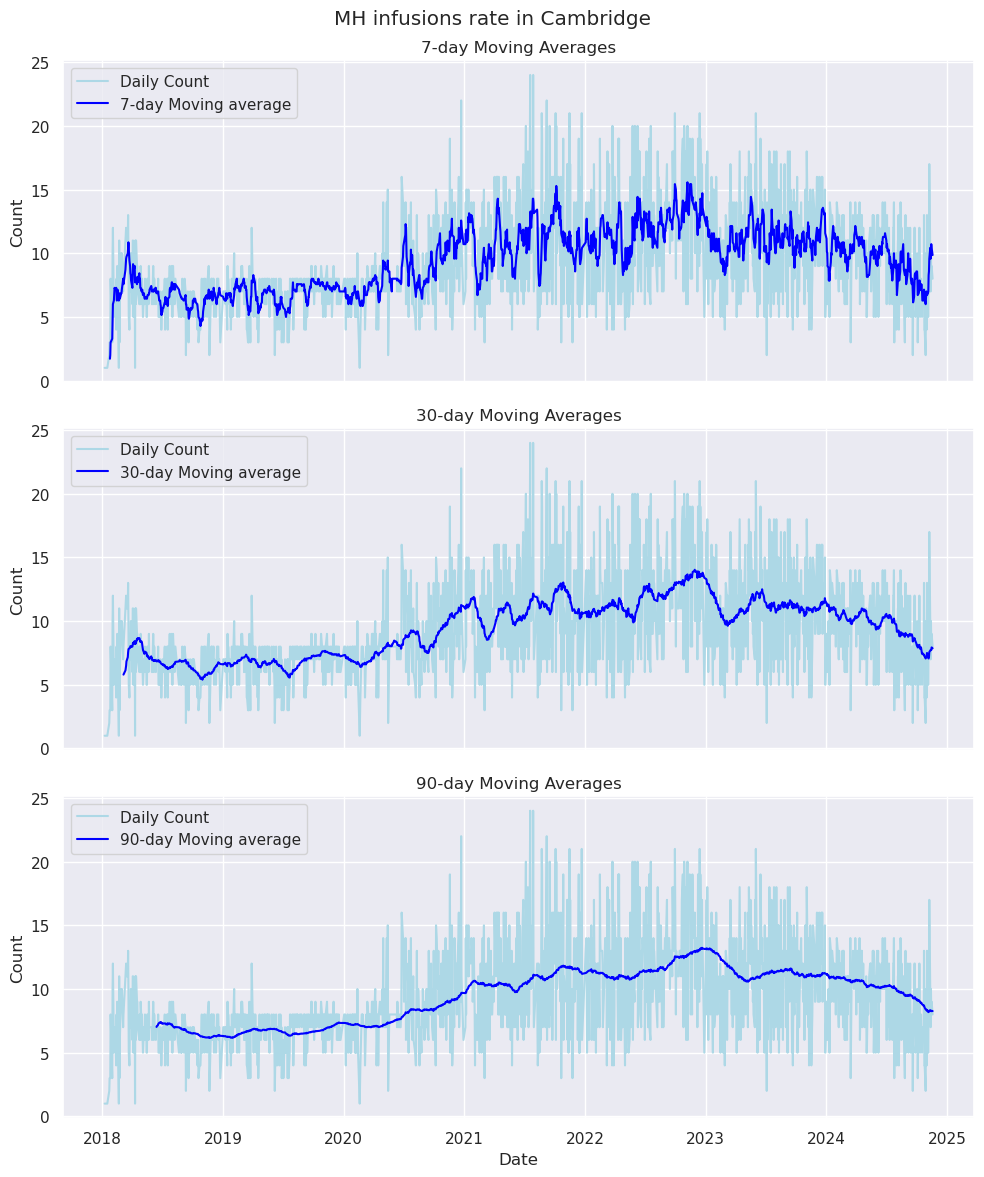

In [20]:
# Create subplots  
fig, axes = plt.subplots(nrows=3, ncols=1,
                        figsize=(10, 12), sharex=True)

# 7-day Moving average plot 
cambridge_mh_success["7_day_MA"] = cambridge_mh_success["appointment_count"].rolling(window=7).mean()
## Plotting
axes[0].plot(cambridge_mh_success.index, cambridge_mh_success["appointment_count"],
        label = "Daily Count", color="lightblue")
axes[0].plot(cambridge_mh_success.index, cambridge_mh_success["7_day_MA"],
        label = "7-day Moving average", color="blue")
axes[0].set_ylabel("Count")

axes[0].set_title("7-day Moving Averages")
axes[0].legend()

# 30-day Moving average plot 
cambridge_mh_success["30_day_MA"] = cambridge_mh_success["appointment_count"].rolling(window=30).mean()
## Plotting
axes[1].plot(cambridge_mh_success.index, cambridge_mh_success["appointment_count"],
        label = "Daily Count", color="lightblue")
axes[1].plot(cambridge_mh_success.index, cambridge_mh_success["30_day_MA"],
        label = "30-day Moving average", color="blue")
axes[1].set_ylabel("Count")

axes[1].set_title("30-day Moving Averages")
axes[1].legend()

# 90-day Moving average plot 
cambridge_mh_success["90_day_MA"] = cambridge_mh_success["appointment_count"].rolling(window=90).mean()
## Plotting
axes[2].plot(cambridge_mh_success.index, cambridge_mh_success["appointment_count"],
        label = "Daily Count", color="lightblue")
axes[2].plot(cambridge_mh_success.index, cambridge_mh_success["90_day_MA"],
        label = "90-day Moving average", color="blue")
axes[2].set_ylabel("Count")

axes[2].set_title("90-day Moving Averages")
axes[2].legend()

plt.suptitle("MH infusions rate in Cambridge")

plt.xlabel("Date")
plt.tight_layout()
plt.show()

From the analysis of the number of daily appointments that involved MH infusion in the camridge facility, it is evident; 

* There is a general rise in the number of appointments from the year 2018 to early 2023
* After mid-2023, the number of appointments start to experience a drop.

#### Successful MH infusion appointments outside Cambridge

I will put all other facilities from the other locations other than Cambridge, analyze the successfull appointments that involve MH infusion and see how they compare with Camdrige. This is what I will do; 

* Filter out Cambridge facilities. 
* Get the successfull appointments that involve MH infusion 
* Clean and organize the data as required 

In [30]:
# Filter the data  
other_mh_success = appointment_df[(appointment_df["Appt Status Description"]=="Seen")\
               &(appointment_df["Facility City"]!="CAMBRIDGE")\
               &(appointment_df["Appt Type Group"]=="MH Infusion")].reset_index(drop=True)



# Clean the data
## Get the required columns 
other_mh_success = other_mh_success[["Date", "Appointment UID", "Facility City"]]

## remove the null values  
other_mh_success.dropna(how="any", inplace=True)
other_mh_success.reset_index(drop=True, inplace=True)

# Drop the facility city column
other_mh_success.drop("Facility City", axis=1, inplace=True)

## Sort values by data 
other_mh_success.sort_values("Date").reset_index(drop=True)

## Group the data by date  
other_mh_success = other_mh_success.groupby("Date").count().reset_index()
other_mh_success.rename({"Appointment UID":"appointment_count"}, 
                            axis=1, inplace=True)

## Drop the first row 
other_mh_success.drop(index=0, inplace=True)
other_mh_success.reset_index(drop=True)

## Set date as index
other_mh_success.set_index("Date", inplace=True)

other_mh_success.head()

,appointment_count
Date,
2023-01-16,1
2023-01-20,2
2023-01-23,2
2023-01-25,2
2023-01-27,1


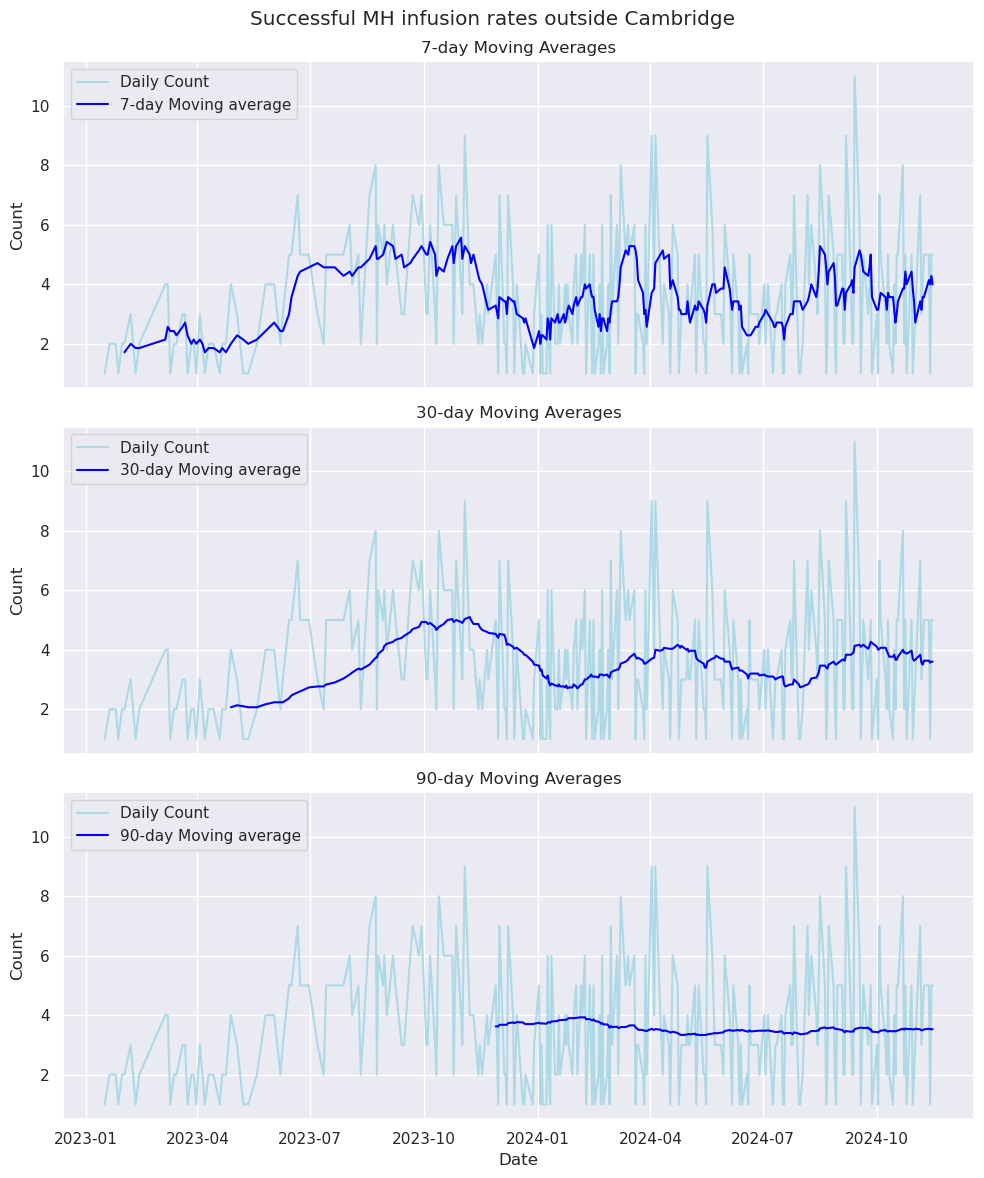

In [31]:
# Create subplots  
fig, axes = plt.subplots(nrows=3, ncols=1,
                        figsize=(10, 12), sharex=True)

# 7-day Moving average plot 
other_mh_success["7_day_MA"] = other_mh_success["appointment_count"].rolling(window=7).mean()
## Plotting
axes[0].plot(other_mh_success.index, other_mh_success["appointment_count"],
        label = "Daily Count", color="lightblue")
axes[0].plot(other_mh_success.index, other_mh_success["7_day_MA"],
        label = "7-day Moving average", color="blue")
axes[0].set_ylabel("Count")

axes[0].set_title("7-day Moving Averages")
axes[0].legend()

# 30-day Moving average plot 
other_mh_success["30_day_MA"] = other_mh_success["appointment_count"].rolling(window=30).mean()
## Plotting
axes[1].plot(other_mh_success.index, other_mh_success["appointment_count"],
        label = "Daily Count", color="lightblue")
axes[1].plot(other_mh_success.index, other_mh_success["30_day_MA"],
        label = "30-day Moving average", color="blue")
axes[1].set_ylabel("Count")

axes[1].set_title("30-day Moving Averages")
axes[1].legend()

# 90-day Moving average plot 
other_mh_success["90_day_MA"] = other_mh_success["appointment_count"].rolling(window=90).mean()
## Plotting
axes[2].plot(other_mh_success.index, other_mh_success["appointment_count"],
        label = "Daily Count", color="lightblue")
axes[2].plot(other_mh_success.index, other_mh_success["90_day_MA"],
        label = "90-day Moving average", color="blue")
axes[2].set_ylabel("Count")

axes[2].set_title("90-day Moving Averages")
axes[2].legend()

plt.suptitle("Successful MH infusion rates outside Cambridge")

plt.xlabel("Date")
plt.tight_layout()
plt.show()

The chart aboves shows that; 

- There rate of successful MH infusions rose over the years and stagnated after mid-2023.
- There are generally less MH infusion rates outside Cambridge than in Cambridge. 

Insights; 

* More marketing is required to bring in more clients for MH infusion. 

### Successfull MH Infusion - mid 2023 onwards
Since there has been a drop in MH infusion from mid 2023 to 2024 in Cambridge Facility, we will explore the data from 2023 and find where did the fall exactly begin. 

In [28]:
# Filter the data 
decided_date = pd.to_datetime("2023-06-01")
cambridge_mh_success_2023 = cambridge_mh_success[cambridge_mh_success.index>=decided_date]
cambridge_mh_success_2023.head()

,appointment_count,7_day_MA,30_day_MA,90_day_MA
Date,,,,
2023-06-01,11,10.857143,11.866667,10.833333
2023-06-02,21,11.857143,12.133333,10.900000
2023-06-05,12,12.285714,12.300000,10.955556
2023-06-06,10,12.285714,12.233333,10.977778
2023-06-07,5,11.857143,12.166667,10.911111


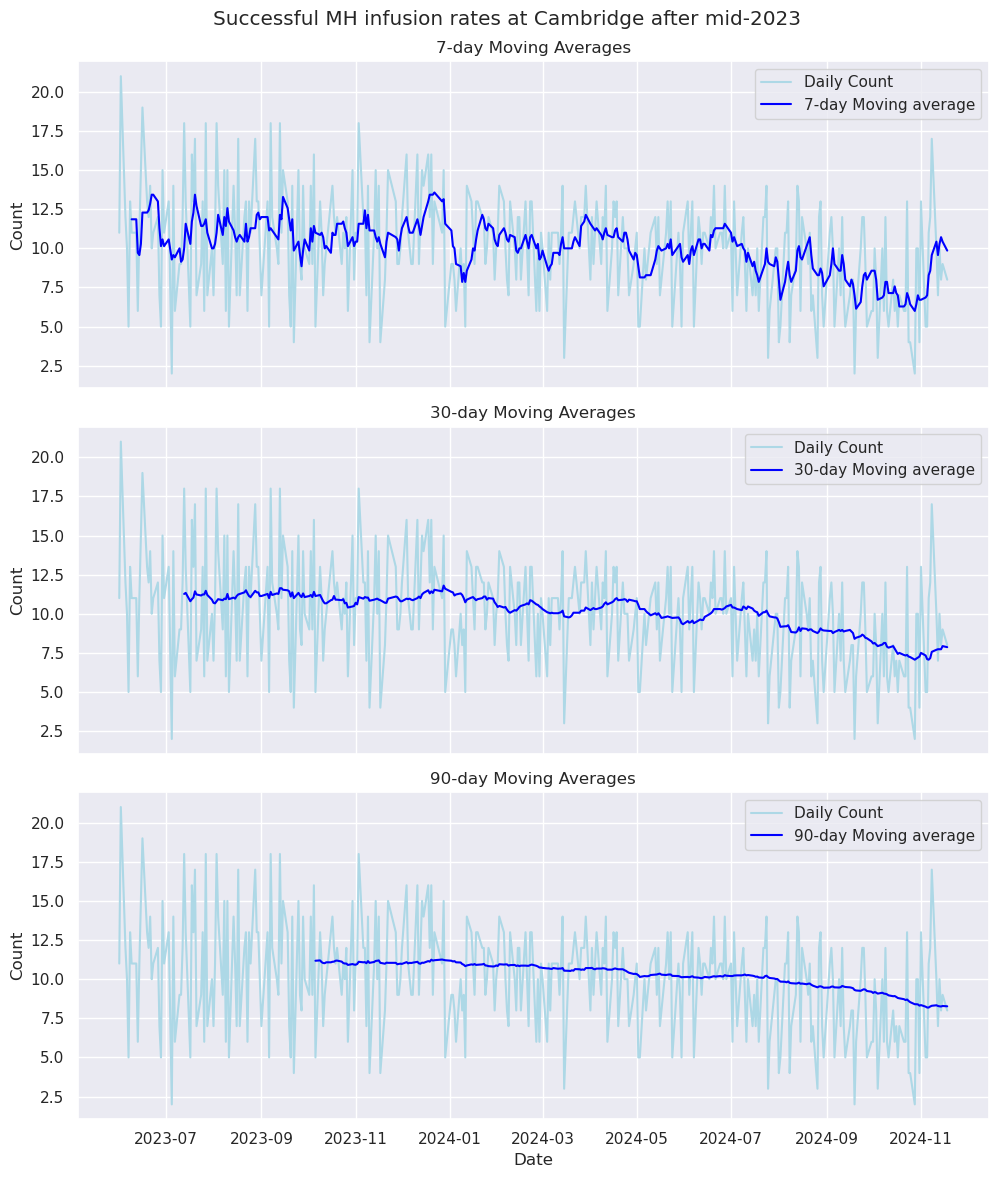

In [29]:
# Create subplots  
fig, axes = plt.subplots(nrows=3, ncols=1,
                        figsize=(10, 12), sharex=True)

# 7-day Moving average plot 
cambridge_mh_success_2023["7_day_MA"] = cambridge_mh_success_2023["appointment_count"].rolling(window=7).mean()
## Plotting
axes[0].plot(cambridge_mh_success_2023.index, cambridge_mh_success_2023["appointment_count"],
        label = "Daily Count", color="lightblue")
axes[0].plot(cambridge_mh_success_2023.index, cambridge_mh_success_2023["7_day_MA"],
        label = "7-day Moving average", color="blue")
axes[0].set_ylabel("Count")

axes[0].set_title("7-day Moving Averages")
axes[0].legend()

# 30-day Moving average plot 
cambridge_mh_success_2023["30_day_MA"] = cambridge_mh_success_2023["appointment_count"].rolling(window=30).mean()
## Plotting
axes[1].plot(cambridge_mh_success_2023.index, cambridge_mh_success_2023["appointment_count"],
        label = "Daily Count", color="lightblue")
axes[1].plot(cambridge_mh_success_2023.index, cambridge_mh_success_2023["30_day_MA"],
        label = "30-day Moving average", color="blue")
axes[1].set_ylabel("Count")

axes[1].set_title("30-day Moving Averages")
axes[1].legend()

# 90-day Moving average plot 
cambridge_mh_success_2023["90_day_MA"] = cambridge_mh_success_2023["appointment_count"].rolling(window=90).mean()
## Plotting
axes[2].plot(cambridge_mh_success_2023.index, cambridge_mh_success_2023["appointment_count"],
        label = "Daily Count", color="lightblue")
axes[2].plot(cambridge_mh_success_2023.index, cambridge_mh_success_2023["90_day_MA"],
        label = "90-day Moving average", color="blue")
axes[2].set_ylabel("Count")

axes[2].set_title("90-day Moving Averages")
axes[2].legend()

plt.suptitle("Successful MH infusion rates at Cambridge after mid-2023")

plt.xlabel("Date")
plt.tight_layout()
plt.show()

The steady fall of successfull appointments that involved MH infusion started exactly on January, 2024. The next goal is to find what really affected the appointment rate. 

Find the difference between; before mid-2023, mid-2023 to the end year(Where it stagnated), start of 2024 to present(where it falls)

# Conclusion